In [1]:
import os
from pathlib import Path
from typing import List, Tuple

import cv2
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

from labelmaker.consensus import VALID_LABEL_SPACES
from labelmaker.label_data import get_ade150, get_nyu40, get_scannet200, get_wordnet


In [2]:
SCENE_ID=47333462
# WORKSPACE_DIR = f'/home/weders/scratch/scratch/LabelMaker/arkitscenes/{SCENE_ID}'
WORKSPACE_DIR = '/scratch/quanta/Experiments/LabelMaker/arkit_test_scene'


In [3]:
# load all model folders
model_folders = [
    x for x in os.listdir(os.path.join(WORKSPACE_DIR, 'intermediate'))
    if x.split('_')[0] in VALID_LABEL_SPACES and x.split('_')[-1] != "lifted"
]
model_folders.sort()
if 'consensus' in os.listdir(os.path.join(WORKSPACE_DIR, 'intermediate')):
  model_folders.append('consensus')


In [4]:
print(model_folders)
model_folders.append('consensus_no_cmx')
model_folders.append('neus_lifted_no_cmx')


['ade20k_internimage_1', 'ade20k_internimage_1_flip', 'nyu40_cmx_1', 'nyu40_cmx_1_flip', 'scannet200_mask3d_1', 'scannet200_mask3d_2', 'wordnet_groundedsam_1', 'wordnet_groundedsam_1_flip', 'wordnet_ovseg_1', 'wordnet_ovseg_1_flip', 'consensus']


In [5]:
# load all images
image_files = sorted([Path(x).stem for x in os.listdir(os.path.join(WORKSPACE_DIR, 'color')) if x.endswith('.jpg')])


In [6]:
# visalization options
vis_freq = 50


In [7]:
len(get_wordnet())


186

In [8]:
COLOR_MAPS = {
    'ade20k': get_ade150,
    'scannet200': get_scannet200,
    'nyu40': get_nyu40,
    'wordnet': get_wordnet,
    'consensus': get_wordnet,
    "sdfstudio": get_wordnet,
}


def load_image(path: str) -> np.ndarray:
  """Load an image from the workspace.
    
    Args:
        image_id (str): image id
    
    Returns:
        np.ndarray: image
    """
  image = cv2.imread(path)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  return image


def load_label(path: str) -> np.ndarray:
  """Load a label from the workspace.
    
    Args:
        label_space (str): label space
        image_id (str): image id
    
    Returns:
        np.ndarray: label
    """
  label = cv2.imread(path, cv2.IMREAD_UNCHANGED)
  # label = np.array(Image.open(path))

  return label


def colorize_label(label: np.ndarray, label_space: str) -> np.ndarray:
  """Colorize a label image for visualization.
    
    Args:
        label (np.ndarray): label image
    
    Returns:
        np.ndarray: colorized label image
    """

  if label_space not in COLOR_MAPS:
    raise ValueError(f'Invalid label space: {label_space}')

  color_maps = {0: [0, 0, 0]}
  for item in COLOR_MAPS[label_space]():
    color_maps[int(item['id'])] = item['color']

  label_colorized = np.zeros((label.shape[0], label.shape[1], 3),
                             dtype=np.uint8)

  for ui in np.unique(label):
    label_colorized[label == ui] = color_maps[ui]

  return label_colorized


In [9]:

import matplotlib.pyplot as plt


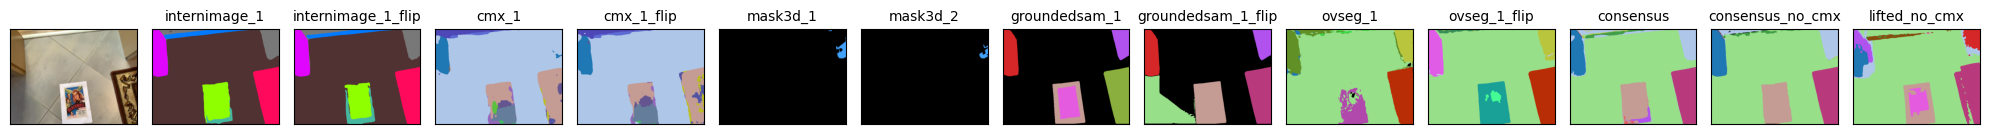

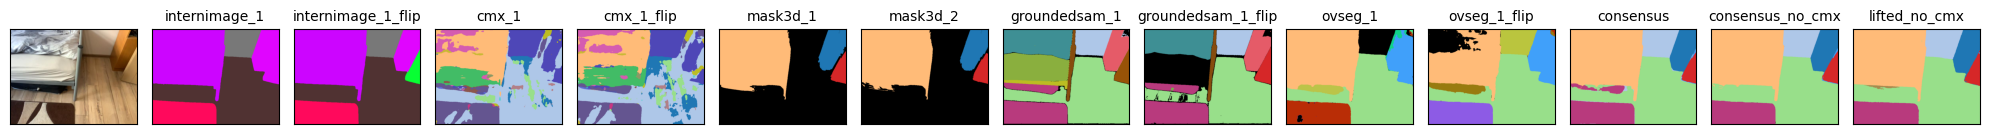

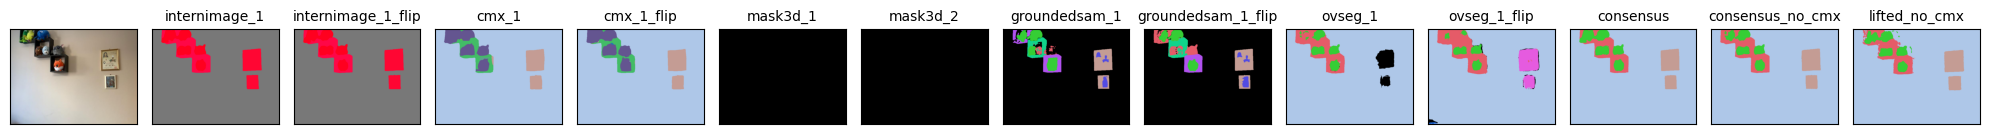

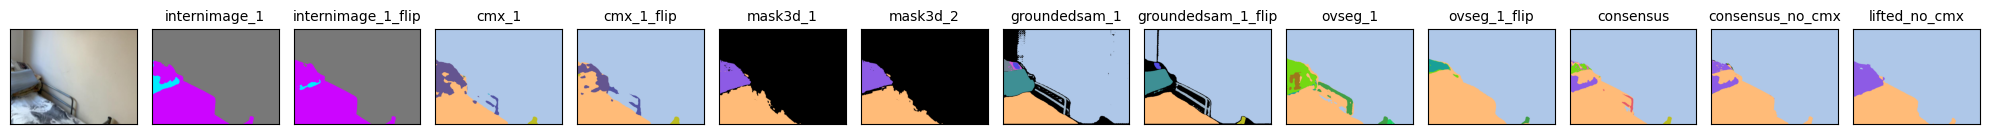

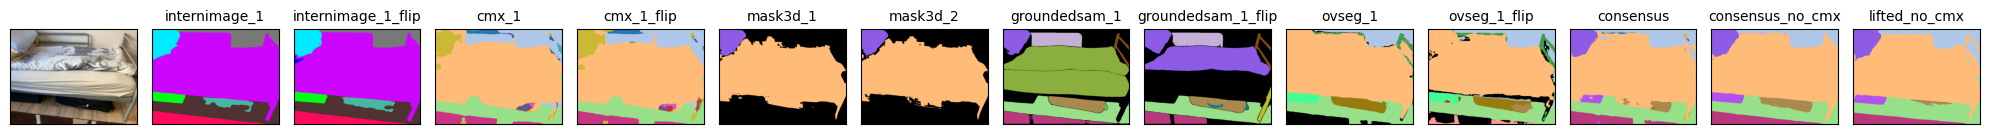

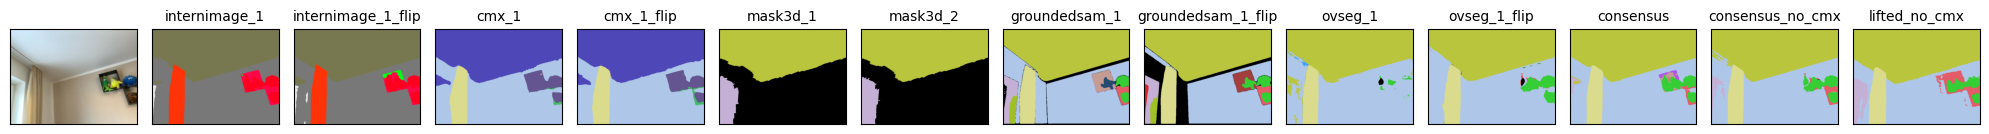

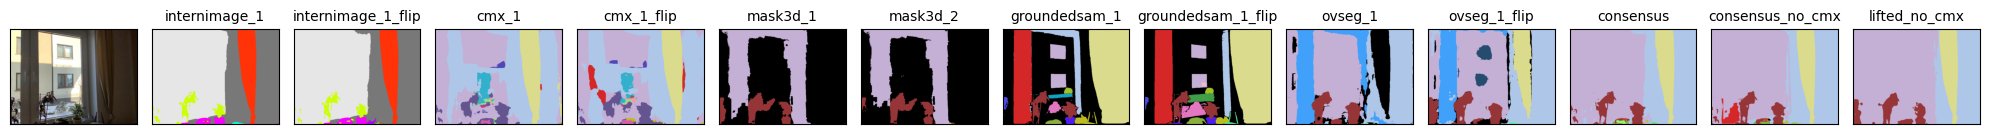

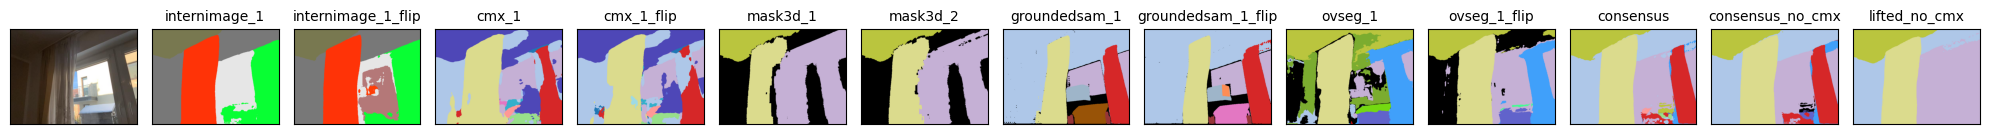

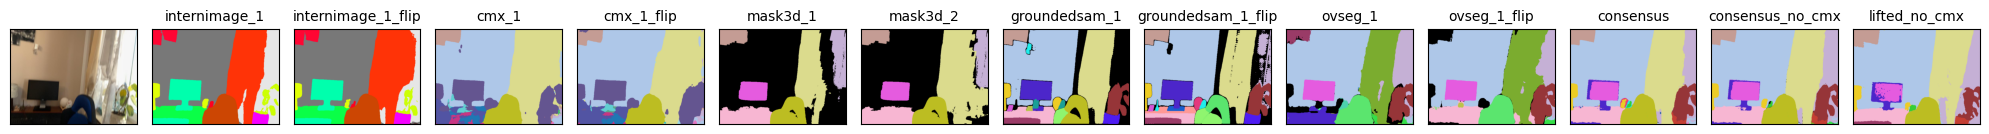

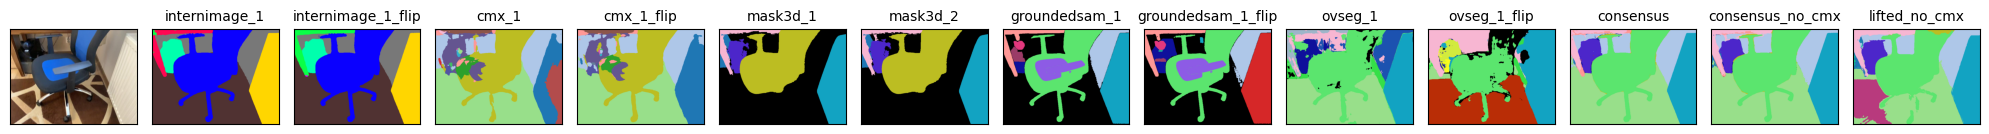

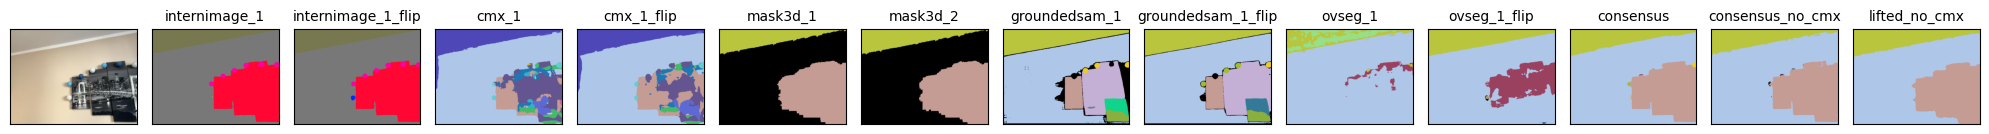

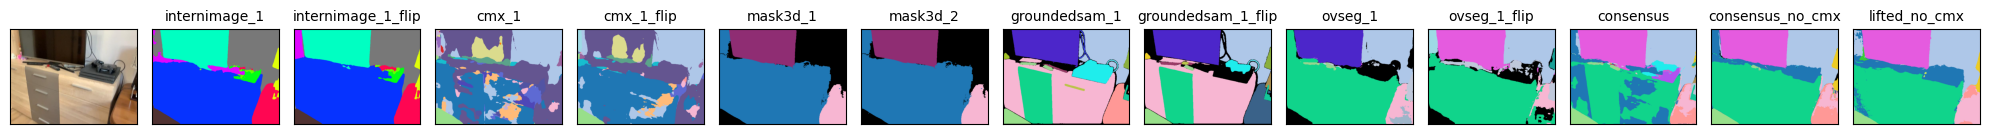

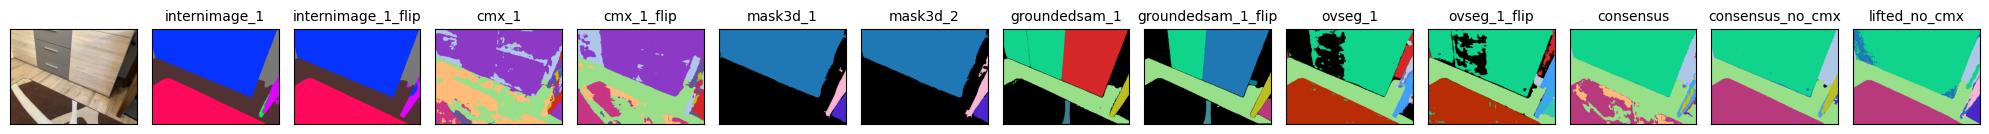

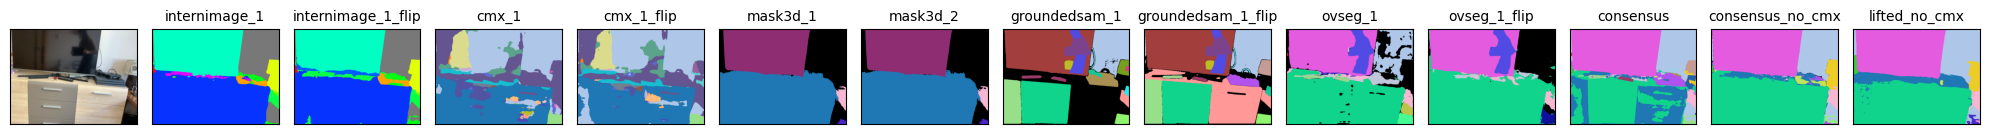

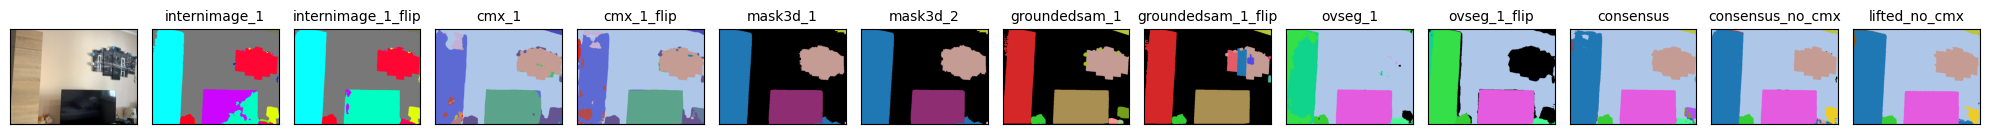

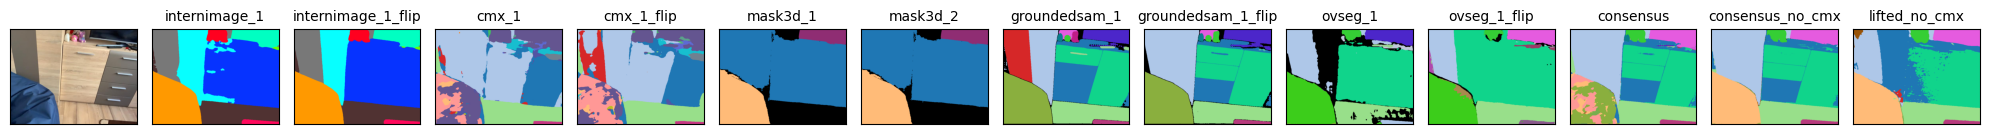

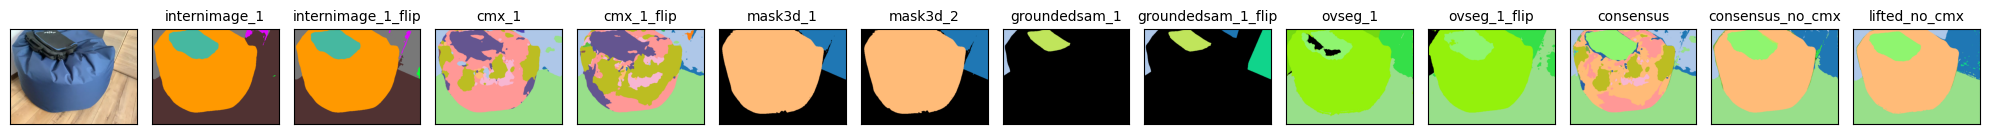

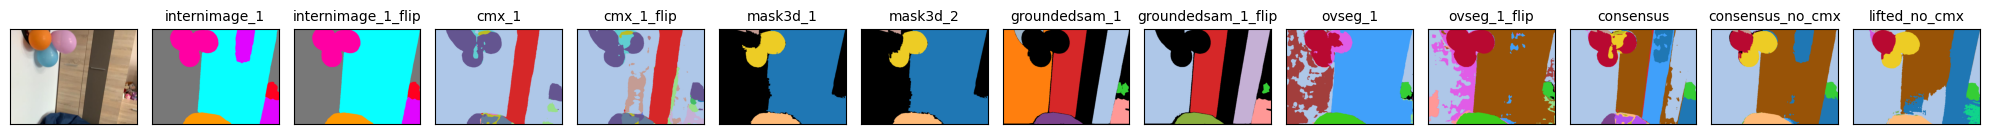

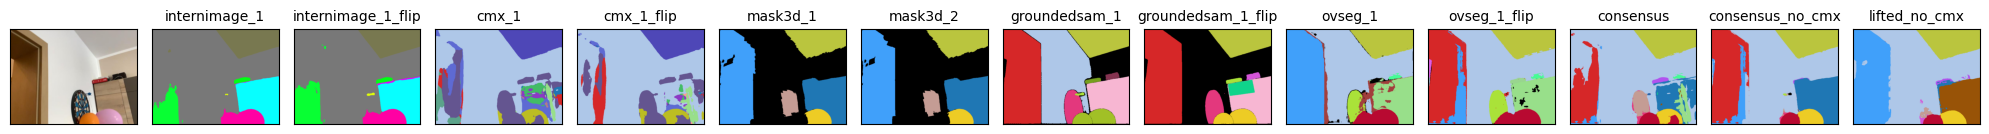

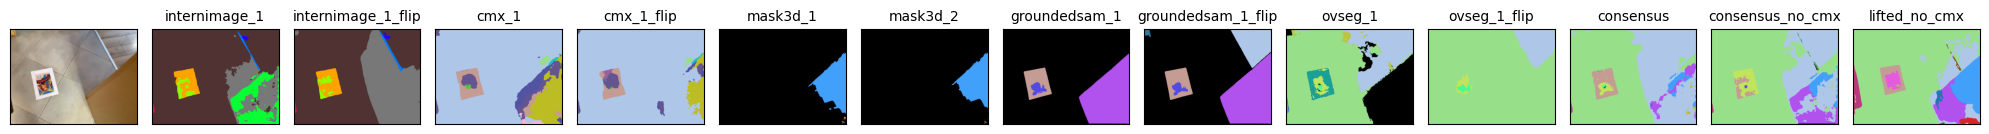

In [10]:
for idx, f in enumerate(image_files):
  if idx % vis_freq == 0:

    image = load_image(os.path.join(WORKSPACE_DIR, 'color', f'{f}.jpg'))
    label_frames = []
    for model_folder in model_folders:
      try:
        if 'lifted' in model_folder:
          label_path = os.path.join(
              WORKSPACE_DIR,
              model_folder,
              '{:05d}.png'.format(int(f)),
          )
        else:
          label_path = os.path.join(
              WORKSPACE_DIR,
              'intermediate',
              model_folder,
              f'{f}.png',
          )
        label = load_label(label_path)
        # print(np.unique(label))
        if 'lifted' in model_folder:
          label = colorize_label(label, "consensus")
        else:
          label = colorize_label(label, model_folder.split('_')[0])
        label_frames.append(label)
      except:
        label_frames.append(np.zeros(shape=(480, 640, 3)))

    fig, ax = plt.subplots(1, len(label_frames) + 1, figsize=(20, 10))
    ax[0].imshow(image)
    for jdx, label_frame in enumerate(label_frames):
      name = model_folders[jdx] if 'consensus' in model_folders[
          jdx] else '_'.join(model_folders[jdx].split('_')[1:])
      ax[jdx + 1].imshow(label_frame)
      ax[jdx + 1].set_title(name, fontsize=10)

    # remove xticks
    for axi in ax:
      axi.set_xticks([])
      axi.set_yticks([])
    plt.tight_layout()
    plt.show()
